## Report: Career Prospects In Data Related Fields


## Key Objectives: 
- Determine factors that affect job salary (regression/classification)
- Determine factors that determine job category/seniority/title/industry (classification)

- Additional: To evaluate models using a confusion matrix that is optimized towards generating false negatives (predict low, actual high) 

- Executive summary

## Document Overview:
1. Data preparation segment
2. Analysis of factors that affect Job Salary
3. Analysis of factors determining Job Class
4. Write Up

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.ensemble import RandomForestClassifier
import statsmodels.formula.api as sm
from sklearn.naive_bayes import MultinomialNB

from pprint import pprint
import scipy.stats as stats
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style="ticks", color_codes=True)

# retroactively added to prevent some warnings from riddling the page
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

## 1. Data preparation

<div class="alert alert-block alert-info">

### Cleaning Checklist
- Use all scraped data from two searches, reset index
- Drop reference number rows then check for duplicates
- Look into null values
- Separating jobs without salary information
- Filter out jobs relevant to data
- Clean up regions =/= north south east west central and impute as islandwide
- Inspect 'islandwide' jobs and make a decision to drop (look at impact and relevance)
- Split jobs by 'to' and create lower and upper salary range
- Check for jobs with annual salary stated and apply a divisor of 12 to both upper and lower range
- Clean up seniority (jobs with multiple seniority stated)
- Finally, drop job link and salary payment type

- Additional preparation: tokenization of Requirements writeups

</div>

In [2]:
# Loading and concatenating two datasets: One for search term: Data; one for search term: Business Intelligence
jobs = pd.read_csv('/Users/paklun/Desktop/materials-master/projects/project-4/Career_Database.csv')
bizint = pd.read_csv('/Users/paklun/Desktop/materials-master/projects/project-4/Career_Database_bizint.csv')
alljobs = pd.concat([jobs,bizint])
alljobs.reset_index(drop=True)

,Unnamed: 0,Unnamed: 0.1,Links,Region,Company,Title,Employment Type,Seniority,Industry,Salary,Payment,Description,Requirements
0,0,0,https://www.mycareersfuture.sg/job/data-engine...,South,MONEYSMART SINGAPORE PTE. LTD.,Data Engineer,Full Time,Executive,Information Technology,"$5,000to$7,000",Monthly,Roles & Responsibilities\nMission\nAs part of ...,Requirements\nCompetencies\nDegree in Computer...
1,1,1,https://www.mycareersfuture.sg/job/data-scient...,South,PORTCAST PTE. LTD.,Data Scientist,Full Time,Middle Management,Engineering,"$2,200to$6,000",Monthly,"Roles & Responsibilities\nIn this role, you wi...",Requirements\n● Comfortable working with larg...
2,2,2,https://www.mycareersfuture.sg/job/data-visual...,Central,SINGAPORE PRESS HOLDINGS LIMITED,Data Visualisation Designer,Permanent,Junior Executive,Design,"$3,500to$4,500",Monthly,Roles & Responsibilities\nDigital arm of Engli...,Requirements\nPrior experience in a data visua...
3,3,3,https://www.mycareersfuture.sg/job/data-analys...,Central,GRABTAXI HOLDINGS PTE. LTD.,Data Analyst,Full Time,Executive,Information Technology,NaN,NaN,Roles & Responsibilities\nGet to know our Team...,Requirements\nThe must haves:\nA Bachelor's/Ma...
4,4,4,https://www.mycareersfuture.sg/job/data-center...,Central,AMAZON ASIA-PACIFIC RESOURCES PRIVATE LIMITED,Data Center Engineering Project Engineer APAC,Full Time,Professional,"Design, Engineering","$9,000to$12,000",Monthly,Roles & Responsibilities\nThe Data Center Glob...,Requirements\nBasic Qualifications -\nMinimum ...
5,5,5,https://www.mycareersfuture.sg/job/lead-data-c...,Central,JOHNSON & JOHNSON PTE. LTD.,Lead Data Center Engineer,Permanent,Professional,"Engineering, Information Technology","$5,000to$10,000",Monthly,Roles & Responsibilities\nThe role of Lead Dat...,Requirements\nRequired Minimum Education: Bac...
6,6,6,https://www.mycareersfuture.sg/job/data-scient...,East,JABIL CIRCUIT (SINGAPORE) PTE. LTD.,Data Scientist - Intern (6 months),Internship,Fresh/entry level,"Information Technology, Manufacturing, Others","$800to$1,500",Monthly,Roles & Responsibilities\nEssential Duties & R...,Requirements\nEducation & Experience Requireme...
7,7,7,https://www.mycareersfuture.sg/job/data-engine...,Islandwide,ADECCO PERSONNEL PTE LTD,Data Engineer,"Contract, Full Time",Executive,Information Technology,"$5,000to$8,500",Monthly,Roles & Responsibilities\nThe Opportunity\nOur...,Requirements\nThe Talent\nMinimum of 3 - 5 yea...
8,8,8,https://www.mycareersfuture.sg/job/data-center...,Central,OPTIMUM SOLUTIONS (SINGAPORE) PTE LTD,Data Center Fiber Optics Cabling Engineer,"Contract, Full Time",Non-executive,Information Technology,"$3,000to$5,000",Monthly,Roles & Responsibilities\nCompany UEN: 1997008...,Requirements\nUrgent & Immediate Position.\nMu...
9,9,9,https://www.mycareersfuture.sg/job/data-analys...,East,EDELMAN SINGAPORE PTE. LTD.,Data Analyst,Full Time,Senior Executive,Others,NaN,NaN,Roles & Responsibilities\nDevelop predictive m...,Requirements\nQualifications\nYou should have ...


In [3]:
# Dropping reference columns
alljobs.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1,inplace=True)
alljobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4300 entries, 0 to 99
Data columns (total 11 columns):
Links              4300 non-null object
Region             4300 non-null object
Company            4283 non-null object
Title              4283 non-null object
Employment Type    4284 non-null object
Seniority          4219 non-null object
Industry           4284 non-null object
Salary             3806 non-null object
Payment            3806 non-null object
Description        4284 non-null object
Requirements       4143 non-null object
dtypes: object(11)
memory usage: 403.1+ KB


In [4]:
# Duplicate check
print('Pre-duplicate drop Shape:',alljobs.shape)
alljobs.drop_duplicates(inplace=True)
print('Post-duplicate drop Shape:',alljobs.shape)

Pre-duplicate drop Shape: (4300, 11)
Post-duplicate drop Shape: (4227, 11)


In [5]:
alljobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4227 entries, 0 to 95
Data columns (total 11 columns):
Links              4227 non-null object
Region             4227 non-null object
Company            4210 non-null object
Title              4210 non-null object
Employment Type    4211 non-null object
Seniority          4146 non-null object
Industry           4211 non-null object
Salary             3736 non-null object
Payment            3736 non-null object
Description        4211 non-null object
Requirements       4071 non-null object
dtypes: object(11)
memory usage: 396.3+ KB


<div class="alert alert-block alert-warning">
Since we might still want to retain job links with salary, lets deal with the entries without Companies and Title before proceeding
    
</div>

In [6]:
alljobs[alljobs['Company'].isnull()]

,Links,Region,Company,Title,Employment Type,Seniority,Industry,Salary,Payment,Description,Requirements
625,https://www.mycareersfuture.sg/job/pre-approva...,South,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
645,https://www.mycareersfuture.sg/job/senior-huma...,East,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
717,https://www.mycareersfuture.sg/job/performance...,East,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
792,https://www.mycareersfuture.sg/job/technical-p...,East,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
846,https://www.mycareersfuture.sg/job/purchasing-...,Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
944,https://www.mycareersfuture.sg/job/transition-...,"South, Central",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1094,https://www.mycareersfuture.sg/job/assistant-l...,South,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1452,https://www.mycareersfuture.sg/job/senior-data...,"South, East, Central",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1684,https://www.mycareersfuture.sg/job/digital-ele...,North,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1811,https://www.mycareersfuture.sg/job/accounts-ex...,East,NaN,NaN,"Permanent, Full Time",Executive,Accounting / Auditing / Taxation,"$2,000to$3,200",Monthly,Roles & Responsibilities\nThe Accounts Executi...,Requirements\n~ Assign account codes to all tr...


In [7]:
alljobs[alljobs['Seniority'].isnull()]

,Links,Region,Company,Title,Employment Type,Seniority,Industry,Salary,Payment,Description,Requirements
39,https://www.mycareersfuture.sg/job/assistant-d...,Permanent,MINISTRY OF DEFENCE,Assistant Director (Integrated Feedback System),Permanent,NaN,"Human Resources , Public / Civil Service",NaN,NaN,"Roles & Responsibilities\nYou lead, develop an...",NaN
137,https://www.mycareersfuture.sg/job/manager-sen...,Full Time,SMART NATION AND DIGITAL GOVERNMENT OFFICE,"Manager / Senior Manager, Finance and Resourci...",Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\nExcited to make a di...,NaN
141,https://www.mycareersfuture.sg/job/senior-mana...,Full Time,SMART NATION AND DIGITAL GOVERNMENT OFFICE,"Senior Manager / Manager (ICT), WOG ICT Infra ...",Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\nAre you a change mak...,NaN
166,https://www.mycareersfuture.sg/job/senior-mana...,Full Time,SKILLSFUTURE SINGAPORE AGENCY,"Senior Manager / Manager, Funding Policy (Reso...",Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\n Responsibilities \...,NaN
422,https://www.mycareersfuture.sg/job/manager-sen...,Full Time,MINISTRY OF MANPOWER,"Manager / Senior Manager, Compliance Strategy ...",Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\nThe job holder is re...,NaN
484,https://www.mycareersfuture.sg/job/procurement...,Full Time,MINISTRY OF HOME AFFAIRS,Procurement Executive,Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\nThe Ministry of Home...,NaN
613,https://www.mycareersfuture.sg/job/assistant-m...,Full Time,MINISTRY OF SOCIAL AND FAMILY DEVELOPMENT,"Assistant Manager (Systems, Exclusion and Visi...",Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\nThe Gambling Safegua...,NaN
619,https://www.mycareersfuture.sg/job/assistant-m...,Full Time,MINISTRY OF SOCIAL AND FAMILY DEVELOPMENT,Assistant Manager / Manager (Child and Family ...,Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\nThe ComCare and Soci...,NaN
625,https://www.mycareersfuture.sg/job/pre-approva...,South,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
645,https://www.mycareersfuture.sg/job/senior-huma...,East,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-warning">
Seems like jobs with Seniority field null are govt jobs and most are not data related & also problematic in the Salary field (null values). We will drop them
    
</div>

In [8]:
# Dropping rows with null values in these 3 columns
alljobs.dropna(subset=['Company','Title','Seniority'],inplace=True)
alljobs.shape

(4145, 11)

In [9]:
alljobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4145 entries, 0 to 95
Data columns (total 11 columns):
Links              4145 non-null object
Region             4145 non-null object
Company            4145 non-null object
Title              4145 non-null object
Employment Type    4145 non-null object
Seniority          4145 non-null object
Industry           4145 non-null object
Salary             3725 non-null object
Payment            3725 non-null object
Description        4145 non-null object
Requirements       4070 non-null object
dtypes: object(11)
memory usage: 388.6+ KB


<div class="alert alert-block alert-warning">
    Let's split the dataset into two, depending if salary is specified.
    </div>

In [10]:
nopay = alljobs[alljobs['Salary'].isnull()].copy().reset_index(drop=True)
nopay.shape

(420, 11)

In [11]:
paidjobs = alljobs[alljobs['Salary'].notnull()].copy().reset_index(drop=True)
print(paidjobs.shape)
paidjobs.tail()

(3725, 11)


,Links,Region,Company,Title,Employment Type,Seniority,Industry,Salary,Payment,Description,Requirements
3720,https://www.mycareersfuture.sg/job/bi-sales-ma...,Central,XPLORE INFOCOMZ SOLUTION (PTE. LTD.),BI Sales Manager (ASEAN),Permanent,Professional,Information Technology,"$6,000to$8,000",Monthly,Roles & Responsibilities\nIt is a Account Mana...,Requirements\n8+ years overall sales experienc...
3721,https://www.mycareersfuture.sg/job/software-en...,South,ENHANZCOM PTE. LTD.,Software Engineer,Full Time,Executive,Information Technology,"$2,200to$2,500",Monthly,Roles & Responsibilities\nMaintain and impleme...,Requirements\nDiploma or Degree in IT or Comp...
3722,https://www.mycareersfuture.sg/job/senior-sale...,Central,MIDEA ELECTRIC TRADING (SINGAPORE) CO. PTE. LTD.,Senior Sales & Marketing Manager,Full Time,"Manager, Executive, Senior Executive","Marketing / Public Relations , Sales / Retail","$5,000to$6,500",Monthly,Roles & Responsibilities\nManager of Sales & M...,Requirements\nExperience & Background\n3+ year...
3723,https://www.mycareersfuture.sg/job/business-in...,South,ADECCO PERSONNEL PTE LTD,Business Intelligence Software Engineer,"Contract, Full Time",Executive,Information Technology,"$5,000to$7,500",Monthly,Roles & Responsibilities\nMain responsibilitie...,Requirements\nThis position requires 5+ years ...
3724,https://www.mycareersfuture.sg/job/business-in...,Central,HAYS SPECIALIST RECRUITMENT PTE. LTD.,Business Intelligence Analyst,"Permanent, Contract, Full Time",Junior Executive,Information Technology,"$4,000to$5,000",Monthly,Roles & Responsibilities\nThis consultancy com...,Requirements\nExcellent communication and stak...


In [12]:
paidjobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3725 entries, 0 to 3724
Data columns (total 11 columns):
Links              3725 non-null object
Region             3725 non-null object
Company            3725 non-null object
Title              3725 non-null object
Employment Type    3725 non-null object
Seniority          3725 non-null object
Industry           3725 non-null object
Salary             3725 non-null object
Payment            3725 non-null object
Description        3725 non-null object
Requirements       3673 non-null object
dtypes: object(11)
memory usage: 320.2+ KB


<div class="alert alert-block alert-warning">
   Filtering data relevant jobs & Setting unclean region data to 'islandwide'
    </div>

In [13]:
# Filtering relevant jobs by Title inclusions
datapaidjobs = paidjobs[paidjobs.Title.str.contains('data|analyst|intelligence|scientist|engineer|tech|python', case=False,regex=True)].copy()
datapaidjobs.Region.value_counts()

Central                        518
East                           227
South                          214
Islandwide                     168
West                           152
North                           76
Full Time                       23
North, Central                   8
East, Central                    8
South, Central                   7
Contract                         7
South, East, Central             6
Permanent                        3
North, West                      2
North, South, Central            2
North, East                      1
North, South, East, Central      1
South, East                      1
Permanent ...                    1
Name: Region, dtype: int64

In [14]:
datapaidjobs.Region[(datapaidjobs.Region != 'Central') & (datapaidjobs.Region != 'South') & (datapaidjobs.Region != 'North') & (datapaidjobs.Region != 'West') & (datapaidjobs.Region != 'East') & (datapaidjobs.Region != 'Islandwide')] = 'Islandwide'
datapaidjobs.Region.value_counts()

Central       518
Islandwide    238
East          227
South         214
West          152
North          76
Name: Region, dtype: int64

In [15]:
datapaidjobs.reset_index(inplace=True, drop=True)
print(datapaidjobs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 11 columns):
Links              1425 non-null object
Region             1425 non-null object
Company            1425 non-null object
Title              1425 non-null object
Employment Type    1425 non-null object
Seniority          1425 non-null object
Industry           1425 non-null object
Salary             1425 non-null object
Payment            1425 non-null object
Description        1425 non-null object
Requirements       1392 non-null object
dtypes: object(11)
memory usage: 122.5+ KB
None


<div class="alert alert-block alert-warning">
    Splitting the salary brackets & dividing salary by 12 for annual types
    </div>

In [16]:
# Splitting the salary string
datapaidjobs['Salary_Min'] = datapaidjobs.Salary.str.split(pat='to').str[0]
datapaidjobs['Salary_Max'] = datapaidjobs.Salary.str.split(pat='to').str[1]
datapaidjobs

,Links,Region,Company,Title,Employment Type,Seniority,Industry,Salary,Payment,Description,Requirements,Salary_Min,Salary_Max
0,https://www.mycareersfuture.sg/job/data-engine...,South,MONEYSMART SINGAPORE PTE. LTD.,Data Engineer,Full Time,Executive,Information Technology,"$5,000to$7,000",Monthly,Roles & Responsibilities\nMission\nAs part of ...,Requirements\nCompetencies\nDegree in Computer...,"$5,000","$7,000"
1,https://www.mycareersfuture.sg/job/data-scient...,South,PORTCAST PTE. LTD.,Data Scientist,Full Time,Middle Management,Engineering,"$2,200to$6,000",Monthly,"Roles & Responsibilities\nIn this role, you wi...",Requirements\n● Comfortable working with larg...,"$2,200","$6,000"
2,https://www.mycareersfuture.sg/job/data-visual...,Central,SINGAPORE PRESS HOLDINGS LIMITED,Data Visualisation Designer,Permanent,Junior Executive,Design,"$3,500to$4,500",Monthly,Roles & Responsibilities\nDigital arm of Engli...,Requirements\nPrior experience in a data visua...,"$3,500","$4,500"
3,https://www.mycareersfuture.sg/job/data-center...,Central,AMAZON ASIA-PACIFIC RESOURCES PRIVATE LIMITED,Data Center Engineering Project Engineer APAC,Full Time,Professional,"Design, Engineering","$9,000to$12,000",Monthly,Roles & Responsibilities\nThe Data Center Glob...,Requirements\nBasic Qualifications -\nMinimum ...,"$9,000","$12,000"
4,https://www.mycareersfuture.sg/job/lead-data-c...,Central,JOHNSON & JOHNSON PTE. LTD.,Lead Data Center Engineer,Permanent,Professional,"Engineering, Information Technology","$5,000to$10,000",Monthly,Roles & Responsibilities\nThe role of Lead Dat...,Requirements\nRequired Minimum Education: Bac...,"$5,000","$10,000"
5,https://www.mycareersfuture.sg/job/data-scient...,East,JABIL CIRCUIT (SINGAPORE) PTE. LTD.,Data Scientist - Intern (6 months),Internship,Fresh/entry level,"Information Technology, Manufacturing, Others","$800to$1,500",Monthly,Roles & Responsibilities\nEssential Duties & R...,Requirements\nEducation & Experience Requireme...,$800,"$1,500"
6,https://www.mycareersfuture.sg/job/data-engine...,Islandwide,ADECCO PERSONNEL PTE LTD,Data Engineer,"Contract, Full Time",Executive,Information Technology,"$5,000to$8,500",Monthly,Roles & Responsibilities\nThe Opportunity\nOur...,Requirements\nThe Talent\nMinimum of 3 - 5 yea...,"$5,000","$8,500"
7,https://www.mycareersfuture.sg/job/data-center...,Central,OPTIMUM SOLUTIONS (SINGAPORE) PTE LTD,Data Center Fiber Optics Cabling Engineer,"Contract, Full Time",Non-executive,Information Technology,"$3,000to$5,000",Monthly,Roles & Responsibilities\nCompany UEN: 1997008...,Requirements\nUrgent & Immediate Position.\nMu...,"$3,000","$5,000"
8,https://www.mycareersfuture.sg/job/data-analys...,Central,ECQUARIA TECHNOLOGIES PTE LTD,Data Analyst,Permanent,"Middle Management, Executive",Information Technology,"$4,000to$5,000",Monthly,"Roles & Responsibilities\nIdentify, analyze, a...","Requirements\nDegree in Computer Science, Info...","$4,000","$5,000"
9,https://www.mycareersfuture.sg/job/senior-data...,Central,AMAZON ASIA-PACIFIC RESOURCES PRIVATE LIMITED,Senior Data Center Infrastructure Availability...,Full Time,Professional,"Building and Construction, Design, Engineering...","$14,000to$17,000",Monthly,Roles & Responsibilities\nAmazon Web Service (...,Requirements\nBASIC QUALIFICATIONS\nBachelor’s...,"$14,000","$17,000"


In [17]:
# Converting the currency type to integer format
datapaidjobs['Salary_Min'] = datapaidjobs['Salary_Min'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.int64)
datapaidjobs['Salary_Max'] = datapaidjobs['Salary_Max'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.int64)
datapaidjobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 13 columns):
Links              1425 non-null object
Region             1425 non-null object
Company            1425 non-null object
Title              1425 non-null object
Employment Type    1425 non-null object
Seniority          1425 non-null object
Industry           1425 non-null object
Salary             1425 non-null object
Payment            1425 non-null object
Description        1425 non-null object
Requirements       1392 non-null object
Salary_Min         1425 non-null int64
Salary_Max         1425 non-null int64
dtypes: int64(2), object(11)
memory usage: 144.8+ KB


In [18]:
# Applying annual->monthly divisor via masking
mask = datapaidjobs[(datapaidjobs.Payment == 'Annually')]
datapaidjobs.loc[(datapaidjobs.Payment == 'Annually'),'Salary_Min'] = round(mask['Salary_Min']/12,2)
datapaidjobs.loc[(datapaidjobs.Payment == 'Annually'),'Salary_Max'] = round(mask['Salary_Max']/12,2)


datapaidjobs[(datapaidjobs.Payment == 'Annually')]

,Links,Region,Company,Title,Employment Type,Seniority,Industry,Salary,Payment,Description,Requirements,Salary_Min,Salary_Max
89,https://www.mycareersfuture.sg/job/reporting-s...,Central,DHL EXPRESS (SINGAPORE) PTE. LTD.,Reporting Senior Analyst,Permanent,Senior Executive,Logistics / Supply Chain,"$65,000to$90,000",Annually,Roles & Responsibilities\nRole Purpose\nBe the...,Requirements\nRequirements\nUniversity degree ...,5416.67,7500.00
126,https://www.mycareersfuture.sg/job/data-center...,Central,UBS AG,Data Center Service Manager,Full Time,Senior Executive,Banking and Finance,"$160,000to$240,000",Annually,Roles & Responsibilities\nAre you passionate a...,Requirements\n- At least 5 years' experience i...,13333.33,20000.00
136,https://www.mycareersfuture.sg/job/data-scient...,Central,SPOTIFY SINGAPORE PTE. LTD.,Data Scientist,Permanent,Executive,Others,"$90,000to$110,000",Annually,Roles & Responsibilities\nWe seek an outstandi...,Requirements\nWho you are\nDegree in Computer ...,7500.00,9166.67
142,https://www.mycareersfuture.sg/job/engineer-bu...,Islandwide,"TURNER BROADCASTING SALES SOUTHEAST ASIA, INC","Engineer, Business Intelligence",Permanent,Executive,Information Technology,"$68,040to$83,160",Annually,Roles & Responsibilities\nThe Business Intelli...,Requirements\nEssential\n1. 4+ years solid exp...,5670.00,6930.00
266,https://www.mycareersfuture.sg/job/analyst-job...,Central,MUFG FUND SERVICES (SINGAPORE) PTE. LTD.,"Analyst, Job",Permanent,Junior Executive,Banking and Finance,"$50,000to$65,000",Annually,Roles & Responsibilities\nEnsure timely and ac...,"Requirements\nHonours degree in Finance, Busin...",4166.67,5416.67
348,https://www.mycareersfuture.sg/job/risk-analys...,Central,MAKO APAC PTE. LTD.,Risk Analyst,"Permanent, Full Time",Executive,Banking and Finance,"$80,000to$90,000",Annually,Roles & Responsibilities\nPosition Details\nTh...,Requirements\nMain Responsibilities\nThe succe...,6666.67,7500.00
368,https://www.mycareersfuture.sg/job/data-scient...,South,CISCO SYSTEMS (USA) PTE. LTD.,Data Scientist,Full Time,"Fresh/entry level, Junior Executive",Banking and Finance,"$57,000to$80,000",Annually,Roles & Responsibilities\n What You'll Do\nAs...,Requirements\nWho You Are\n• Thrive in a multi...,4750.00,6666.67
448,https://www.mycareersfuture.sg/job/lead-data-s...,South,BIGTAPP PTE. LTD.,Lead Data Scientist,Full Time,Senior Executive,"Consulting , Information Technology","$80,000to$100,000",Annually,Roles & Responsibilities\nThe position involve...,Requirements\nMinimum of 6 to 8 years of Data ...,6666.67,8333.33
451,https://www.mycareersfuture.sg/job/data-soluti...,Central,MICROSOFT OPERATIONS PTE LTD,Data Solution Architect,Full Time,Non-executive,Information Technology,"$164,500to$246,500",Annually,Roles & Responsibilities\nMicrosoft envisions ...,Requirements\nExperiences Required:\n* Technic...,13708.33,20541.67
464,https://www.mycareersfuture.sg/job/business-in...,East,INFOCEPTS PTE. LTD.,Business Intelligence - Senior Program Manager,Full Time,Senior Management,"Consulting , Information Technology","$118,800to$145,200",Annually,Roles & Responsibilities\nPosition ...,Requirements\nQualifications & Skills:-\nShoul...,9900.00,12100.00


In [19]:
datapaidjobs['Salary_Avg'] = (datapaidjobs['Salary_Max']+datapaidjobs['Salary_Min'])/2
datapaidjobs.describe()

,Salary_Min,Salary_Max,Salary_Avg
count,1425.000000,1425.000000,1425.000000
mean,5068.922568,7962.427607,6515.675088
std,3276.944289,5336.939439,4158.725298
min,20.000000,800.000000,650.000000
25%,3400.000000,5000.000000,4300.000000
50%,4800.000000,7000.000000,6000.000000
75%,6000.000000,9500.000000,8000.000000
max,60000.000000,85000.000000,70000.000000


In [20]:
# Dropping useless columns
datapaidjobs.drop(['Links','Salary','Payment'],inplace=True, axis=1)
datapaidjobs.shape

(1425, 11)

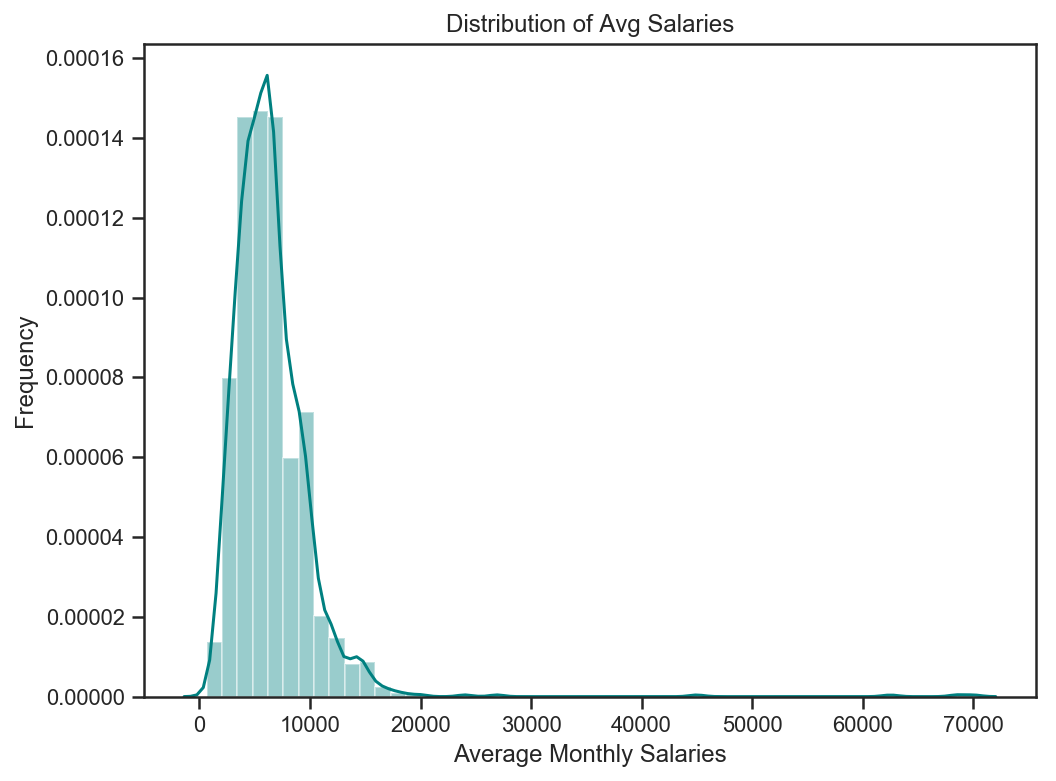

In [21]:
plt.figure(figsize=(8,6))
sns.distplot(datapaidjobs.Salary_Avg,bins=50,color='Teal')
plt.xlabel('Average Monthly Salaries')
plt.ylabel('Frequency')
plt.title('Distribution of Avg Salaries');

<div class="alert alert-block alert-warning">
Seems like the avg monthly salaries are distributed normally below $20000, with a handful of outliers between 20k - 70k skewing the data. Let's investigate the extreme outliers.
</div>

In [22]:
datapaidjobs[(datapaidjobs.Salary_Avg >= 30000)]

,Region,Company,Title,Employment Type,Seniority,Industry,Description,Requirements,Salary_Min,Salary_Max,Salary_Avg
479,North,NCS PTE. LTD.,Lead / Senior Database Administrator,Permanent,Professional,Information Technology,Roles & Responsibilities\nPosition Summary\nSe...,Requirements\nMinimum 3 years of experience in...,5000.0,85000.0,45000.0
616,Central,COMPANY UNDISCLOSED,Research Engineer,Full Time,Fresh/entry level,Information Technology,Roles & Responsibilities\nCOMPANY DESCRIPTION\...,Requirements\nRequired Skills:\nBS/MS in Compu...,60000.0,80000.0,70000.0
1127,Central,DTCC DATA REPOSITORY (SINGAPORE) PTE. LTD.,Senior Business Systems Analyst,Full Time,Senior Executive,Information Technology,Roles & Responsibilities\nBusiness Unit Descri...,Requirements\nQualifications\nMinimum of 8 yea...,50000.0,75000.0,62500.0
1335,East,VISA WORLDWIDE PTE. LIMITED,"New Grad, Senior Software Engineer (Master's D...",Full Time,Fresh/entry level,Information Technology,"Roles & Responsibilities\nCommon Purpose, Unco...",Requirements\nSo what are we looking for in a ...,57000.0,80000.0,68500.0


<div class="alert alert-block alert-warning">
    Seems like the outliers are likely erroneous entries, so we shall drop
</div>

In [23]:
# Subsetting jobs
datapaidjobs2 = (datapaidjobs[(datapaidjobs.Salary_Avg <= 30000)]).copy().reset_index()
datapaidjobs2.shape

(1421, 12)

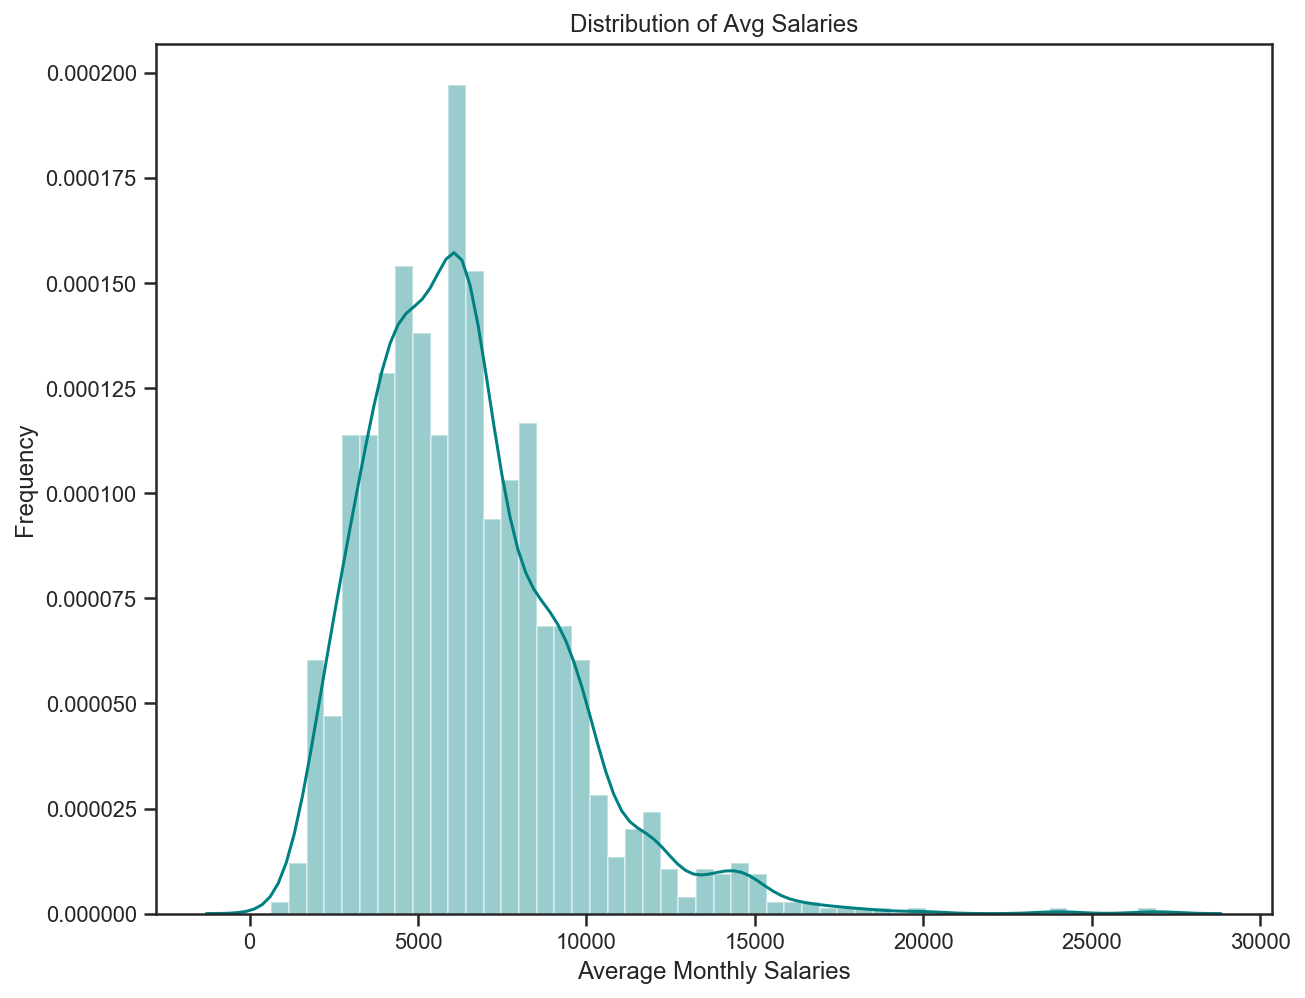

In [24]:
plt.figure(figsize=(10,8))
sns.distplot(datapaidjobs2.Salary_Avg,bins=50,color='teal')
plt.xlabel('Average Monthly Salaries')
plt.ylabel('Frequency')
plt.title('Distribution of Avg Salaries');

<div class="alert alert-block alert-warning">
Then, we will clean up seniority & employment type using a self defined function to manually simulate getting dummy variables from multi-category inputs
</div>

In [25]:
#write a function that will create dummy variables when the field has multiple options/categories

def create_dummy(colname,df):
    
    all_cat = set()
    #this is a set containing all the possible categories and we will feature engineer the corresponding number of columns

    cat_list = df[colname].str.replace(' , ',', ').str.split(', ')
#     print(len(cat_list))
    
    for category in cat_list:
        #create a column
        for i in category:
            all_cat.add(i)
        
    
    #create a list of dictionaries, to be converted to dataframe later on
    cat_dummies = []
    
    #for each category that is listed for that row
    for category in cat_list:
        row = {}
        for cat in all_cat:#for all possible categories
            if cat in category:
                row[cat] = 1 #this job listing has listed this employment type
            else:
                row[cat] = 0 #this job listing did not list this employment type
                    
        cat_dummies.append(row)        
    
    dummy_df = pd.DataFrame(cat_dummies)#convert list of dictionaries to dataframe
    
    return dummy_df

In [26]:
# creating a dummy variable df for seniority
senioritydummy = create_dummy('Seniority',datapaidjobs2)
senioritydummy.shape

(1421, 9)

In [27]:
# creating a dummy variable df for employment types
employmentdummy = create_dummy('Employment Type',datapaidjobs2)
employmentdummy.shape

(1421, 8)

In [28]:
# creating a dummy variable df for industry types
industrydummy = create_dummy('Industry',datapaidjobs2)
industrydummy.shape

(1421, 36)

In [29]:
# merging all datasets together and then dropping
datapaidjobsdummy = pd.concat([datapaidjobs2,employmentdummy,senioritydummy,industrydummy],axis=1)
datapaidjobsdummied = datapaidjobsdummy.copy()
datapaidjobsdummied.drop(['index','Permanent','Fresh/entry level','Design'],inplace=True,axis=1)
datapaidjobsdummied.head()

,Region,Company,Title,Employment Type,Seniority,Industry,Description,Requirements,Salary_Min,Salary_Max,...,Public / Civil Service,Purchasing / Merchandising,Real Estate / Property Management,Repair and Maintenance,Risk Management,Sales / Retail,Sciences / Laboratory / R&D,Security and Investigation,Telecommunications,Travel / Tourism
0,South,MONEYSMART SINGAPORE PTE. LTD.,Data Engineer,Full Time,Executive,Information Technology,Roles & Responsibilities\nMission\nAs part of ...,Requirements\nCompetencies\nDegree in Computer...,5000.0,7000.0,...,0,0,0,0,0,0,0,0,0,0
1,South,PORTCAST PTE. LTD.,Data Scientist,Full Time,Middle Management,Engineering,"Roles & Responsibilities\nIn this role, you wi...",Requirements\n● Comfortable working with larg...,2200.0,6000.0,...,0,0,0,0,0,0,0,0,0,0
2,Central,SINGAPORE PRESS HOLDINGS LIMITED,Data Visualisation Designer,Permanent,Junior Executive,Design,Roles & Responsibilities\nDigital arm of Engli...,Requirements\nPrior experience in a data visua...,3500.0,4500.0,...,0,0,0,0,0,0,0,0,0,0
3,Central,AMAZON ASIA-PACIFIC RESOURCES PRIVATE LIMITED,Data Center Engineering Project Engineer APAC,Full Time,Professional,"Design, Engineering",Roles & Responsibilities\nThe Data Center Glob...,Requirements\nBasic Qualifications -\nMinimum ...,9000.0,12000.0,...,0,0,0,0,0,0,0,0,0,0
4,Central,JOHNSON & JOHNSON PTE. LTD.,Lead Data Center Engineer,Permanent,Professional,"Engineering, Information Technology",Roles & Responsibilities\nThe role of Lead Dat...,Requirements\nRequired Minimum Education: Bac...,5000.0,10000.0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Distribution of Available Positions by Seniority')

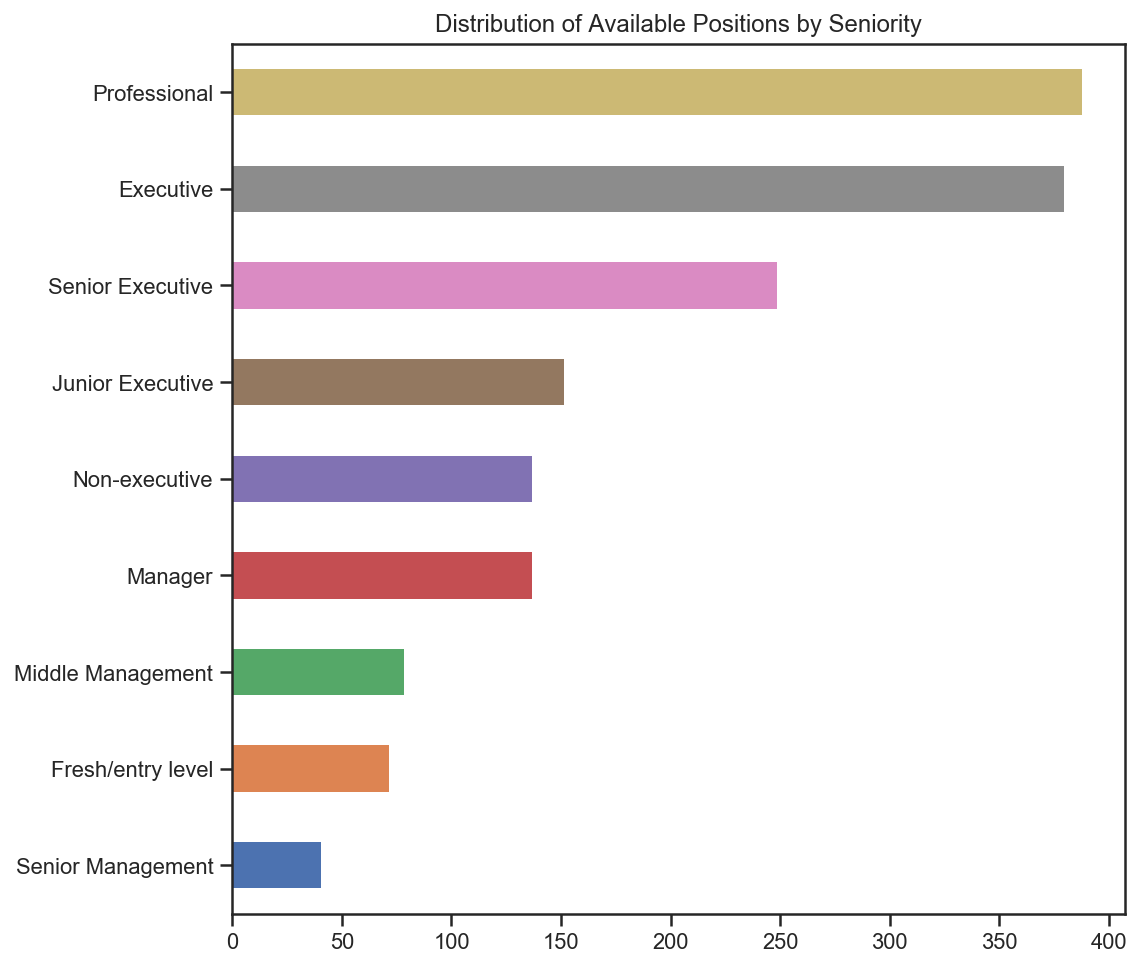

In [30]:
plt.figure(figsize=(8,8))
datapaidjobsdummy[['Executive', 'Fresh/entry level',
       'Junior Executive', 'Manager', 'Middle Management', 'Non-executive',
       'Professional', 'Senior Executive', 'Senior Management']].sum().sort_values().plot(kind='barh')
plt.title('Distribution of Available Positions by Seniority')

<div class="alert alert-block alert-warning">
We now have one-hot encoded a Permanent, Fresh/Entry, Design job as the default. We will try modelling for salary factors with these. Thereafter we will apply NLP on requirements to model for other factors.
</div>

## 2. Modeling for Salary

<div class="alert alert-block alert-info">

### Modeling approach
- Try (minus Descriptions and Requirements)
- Test logistic regressions with dummified fields and Salary 
- Test with Random Forest Classifier


</div>

### Model pre-prep

In [31]:
datapaidjobsdummied.Salary_Avg.describe()

count     1421.000000
mean      6360.898663
std       2919.872345
min        650.000000
25%       4250.000000
50%       6000.000000
75%       7750.000000
max      26900.000000
Name: Salary_Avg, dtype: float64

In [32]:
# Binary Labelling using Median Salary_avg
datapaidjobsdummied['Salary_Label'] = datapaidjobsdummied['Salary_Avg'].apply(lambda x: 0 if x < 6000 else 1)
datapaidjobsdummied.Salary_Label.describe()

count    1421.000000
mean        0.533427
std         0.499057
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Salary_Label, dtype: float64

Baseline accuracy for High Pay is 53.3%

In [33]:
modeldf = datapaidjobsdummied.drop(['Company','Seniority','Description','Requirements','Salary_Min','Salary_Max','Employment Type','Title','Industry'],axis=1)
X = pd.get_dummies(modeldf.drop(['Salary_Avg','Salary_Label'],axis=1),drop_first=True)
X

,Contract,Flexi work,Freelance,Full Time,Internship,Part Time,Temporary,Executive,Junior Executive,Manager,...,Sales / Retail,Sciences / Laboratory / R&D,Security and Investigation,Telecommunications,Travel / Tourism,Region_East,Region_Islandwide,Region_North,Region_South,Region_West
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
7,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
y = modeldf['Salary_Label']
y.shape

(1421,)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=127, stratify=y)

## Model: Log Reg

In [36]:
LogReg = LogisticRegression(solver='lbfgs',max_iter=300)
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [37]:
y_pred = LogReg.predict(X_test)
CM = confusion_matrix(y_test, y_pred)
log_cv_score = cross_val_score(LogReg, X, y, cv=10, scoring='roc_auc')
print('Logistic Regression Results')
print('----------------------------------------------')
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(LogReg.score(X_test, y_test))) 
print('----------------------------------------------')
print(classification_report(y_test, y_pred))
print('----------------------------------------------')
print('Confusion Matrix')
print(CM)
print('----------------------------------------------')
print('Mean AUC Score')
print(log_cv_score.mean())



Logistic Regression Results
----------------------------------------------
Accuracy of logistic regression classifier on test set: 0.72
----------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       166
           1       0.72      0.78      0.75       190

   micro avg       0.72      0.72      0.72       356
   macro avg       0.72      0.71      0.72       356
weighted avg       0.72      0.72      0.72       356

----------------------------------------------
Confusion Matrix
[[108  58]
 [ 42 148]]
----------------------------------------------
Mean AUC Score
0.772171846112341


In [38]:
logregcoefdf = pd.DataFrame(LogReg.coef_, columns=X.columns.values.tolist())
logregcoefdf2 = pd.melt(logregcoefdf, var_name = 'Variable', value_name='Weight')
logregcoefdf2.sort_values(by='Weight', ascending = False,inplace=True)
logregcoefdf2.head(10)

,Variable,Weight
14,Senior Management,1.436255
10,Middle Management,1.092103
9,Manager,0.970624
13,Senior Executive,0.827898
12,Professional,0.773132
21,Consulting,0.676436
31,Information Technology,0.586330
26,General Management,0.446010
34,Logistics / Supply Chain,0.350567
19,Banking and Finance,0.345759


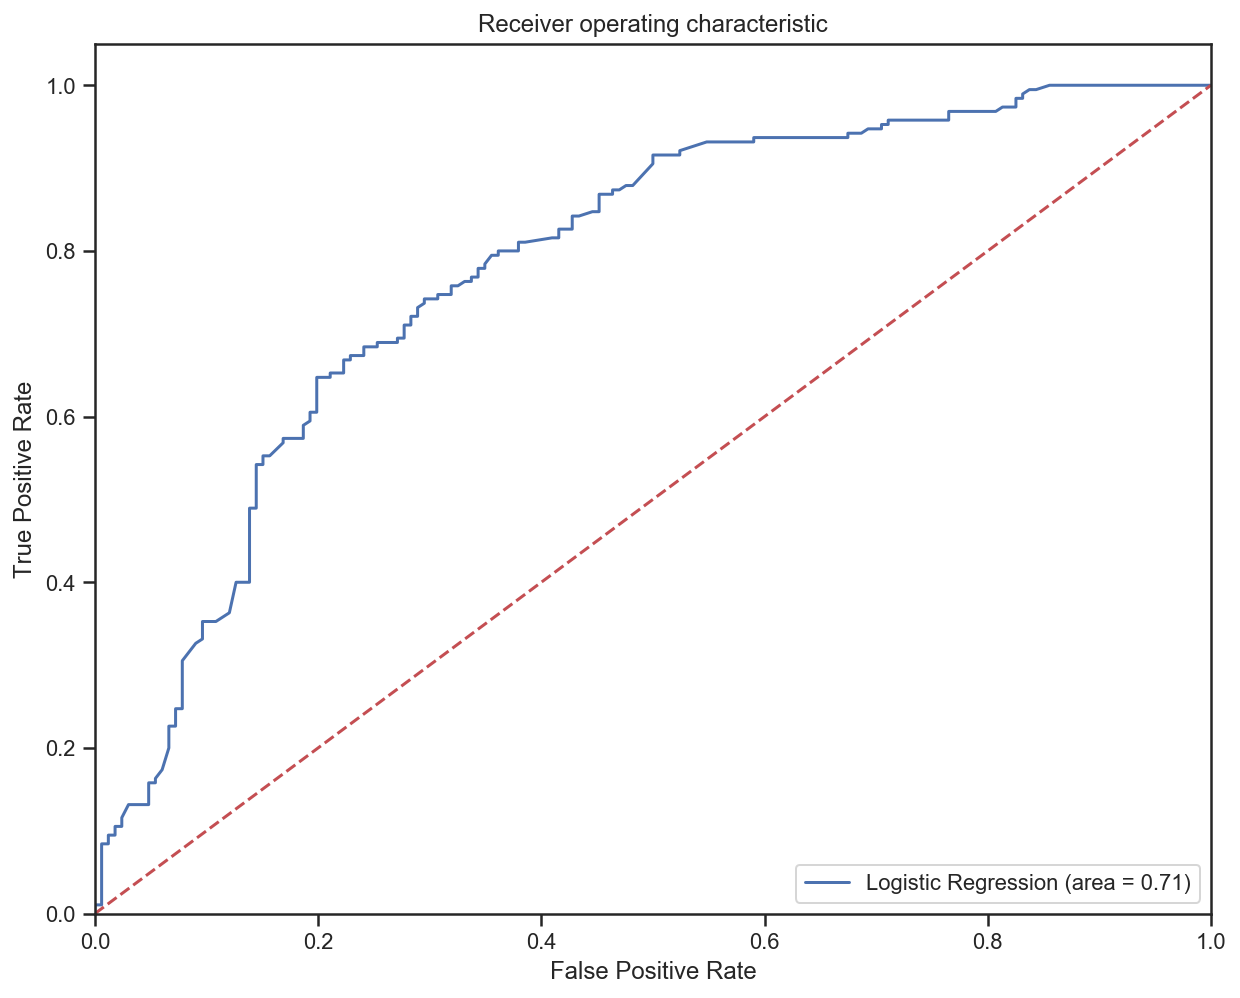

In [39]:
log_roc_auc = roc_auc_score(y_test, LogReg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, LogReg.predict_proba(X_test)[:,1])

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % log_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Model: Random Forest

In [40]:
rfc = RandomForestClassifier(n_estimators=300)
rfc.fit(X_train,y_train)

y_pred_rfc = rfc.predict(X_test)

In [41]:
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
CMrfc = confusion_matrix(y_test, y_pred_rfc)
print('Random Forest Results')
print('----------------------------------------------')
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rfc.score(X_test, y_test))) 
print('----------------------------------------------')
print(classification_report(y_test, y_pred_rfc))
print('----------------------------------------------')
print('Confusion Matrix')
print(CMrfc)
print('----------------------------------------------')
print('Mean AUC Score')
print(rfc_cv_score.mean())

Random Forest Results
----------------------------------------------
Accuracy of Random Forest classifier on test set: 0.73
----------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       166
           1       0.71      0.84      0.77       190

   micro avg       0.73      0.73      0.73       356
   macro avg       0.74      0.73      0.73       356
weighted avg       0.74      0.73      0.73       356

----------------------------------------------
Confusion Matrix
[[101  65]
 [ 30 160]]
----------------------------------------------
Mean AUC Score
0.7719880977885691


In [42]:
rfcfeatdf = pd.DataFrame(rfc.feature_importances_, index=X.columns.values.tolist())
rfcfeatdf.rename(columns={0:'Weight'},inplace=True)
rfcfeatdf.sort_values(by='Weight', ascending = False,inplace=True)
rfcfeatdf.head(10)

,Weight
Junior Executive,0.075916
Executive,0.063213
Full Time,0.061776
Information Technology,0.061727
Contract,0.054150
Professional,0.051926
Region_Islandwide,0.047043
Engineering,0.044570
Region_South,0.041435
Senior Executive,0.041075


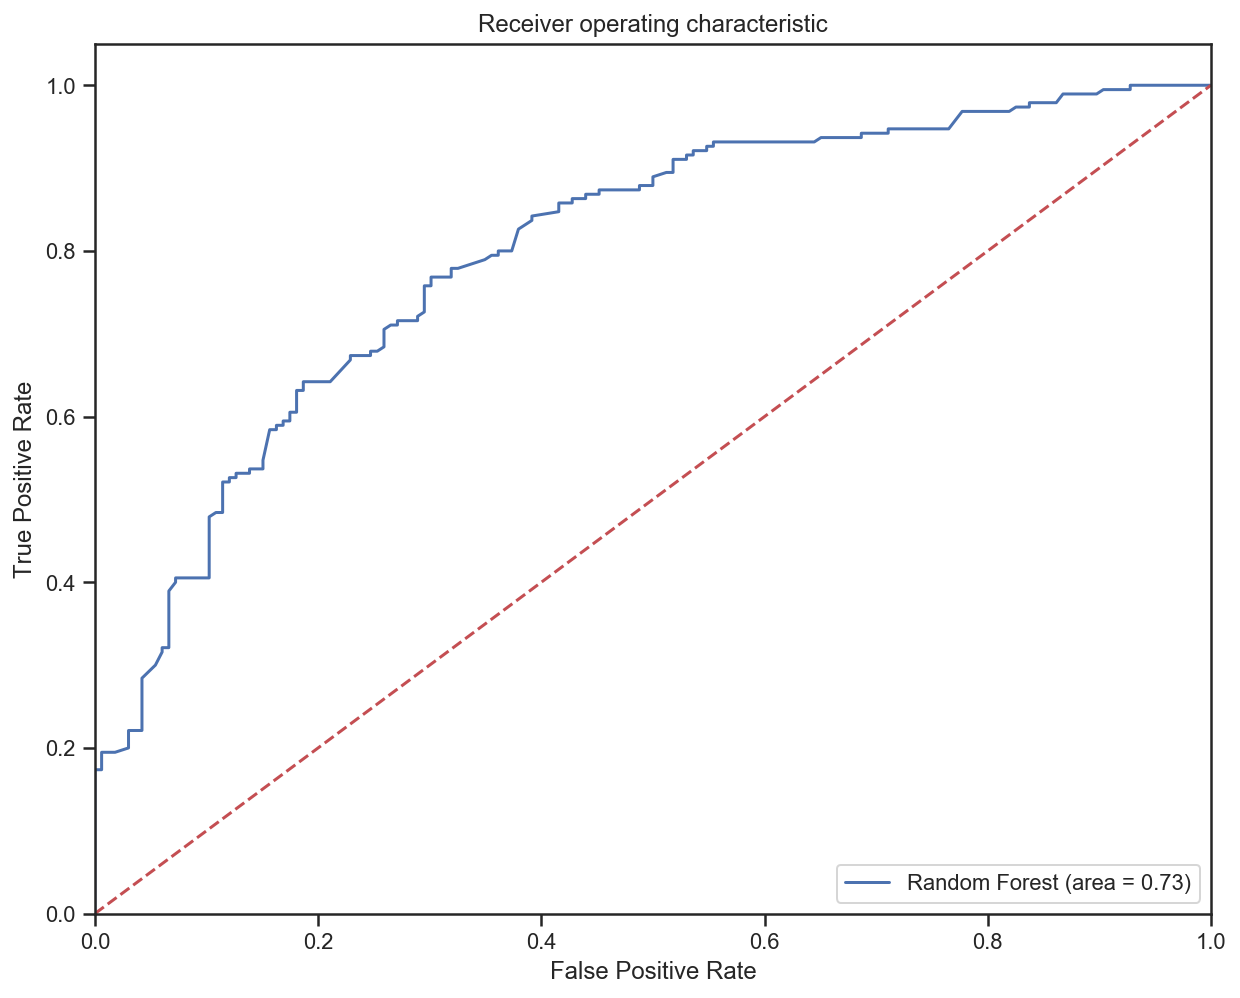

In [43]:
rfc_roc_auc = roc_auc_score(y_test, rfc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rfc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [44]:
print('Logistic Regression Confusion Matrix')
print(CM)
print('-----------------------------------------------')
print('Random Forest Confusion Matrix')
print(CMrfc)

Logistic Regression Confusion Matrix
[[108  58]
 [ 42 148]]
-----------------------------------------------
Random Forest Confusion Matrix
[[101  65]
 [ 30 160]]



<div class="alert alert-block alert-warning">
    
- Both versatile models performed very closely in accuracies and mean AUC scores.
    
- Analysing the top 10 impactful factors derived from Log Reg, it appears that Senior positions (manager/mid-mgmt/Snr Mgmt) & Function in Industries are the strongest factors. 
 
- Consulting & Banking would stand out as the better paying jobs.

- Comparing confusion matrixes, Logistic Regression gave a better probability of giving us False Negatives, where the model predicts a low pay for an actually higher paying job. From a business perspective, this is better (and what we want to optimise our False predictions towards) as it results in happier clients.

</div>

## 3. Factors impacting job title or categories

<div class="alert alert-block alert-info">

### Segment approach: NLP on requirements
- Prepare textual columns for NLP 
- Process the text using countvectorizer
- Determine categories & targets to be predicted
- Model with MultinomialNB / RF

</div>

## We will look at factors impacting seniority since titles can be very diverse

In [45]:
# Cleaning some scrap noise and segment headers
datapaidjobsdummied['Description'] = datapaidjobsdummied['Description'].str.replace('\n',' ').str.replace('Roles & Responsibilities','')
datapaidjobsdummied['Requirements'] = datapaidjobsdummied['Requirements'].str.replace('\n',' ').str.replace('Requirements','')

In [46]:
custom_stop_words = list(ENGLISH_STOP_WORDS)

# Custom stopwords that are usual recruiter fluff
custom_stop_words.extend(['12c6060','14c7279','000','ea','reg','06c4642','including','justin','chen','apply','talent','candidate','email','cv','resume','careers','opportunities','www','http','taleo','visit','ideal','assessment','require','undertake','com','able','good','looking','jobs','personnel','helping','requirement','join','come','strongly','registration'])
# Adding custom stop word for next step , just in case
custom_stop_words.append('is')

len(custom_stop_words)

356

In [47]:
# Null value in requirements throw error when doing countvectorizing, so imputing a stop-word so that it doesn't affect the data
datapaidjobsdummied.Requirements.fillna('is',inplace=True)
datapaidjobsdummied.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 62 columns):
Region                               1421 non-null object
Company                              1421 non-null object
Title                                1421 non-null object
Employment Type                      1421 non-null object
Seniority                            1421 non-null object
Industry                             1421 non-null object
Description                          1421 non-null object
Requirements                         1421 non-null object
Salary_Min                           1421 non-null float64
Salary_Max                           1421 non-null float64
Salary_Avg                           1421 non-null float64
Contract                             1421 non-null int64
Flexi work                           1421 non-null int64
Freelance                            1421 non-null int64
Full Time                            1421 non-null int64
Internship              

In [48]:
# Capping max features at 20k and n-grams up to 3 words
cvec = CountVectorizer(stop_words=custom_stop_words, ngram_range=(1,3), min_df=2,max_df=0.9,max_features=20000 )
Xcvec = cvec.fit_transform(datapaidjobsdummied['Requirements'])
cvec.vocabulary_

{'competencies': 3210,
 'degree': 4487,
 'computer': 3325,
 'science': 15346,
 'years': 19856,
 'relevant': 14593,
 'working': 19625,
 'experience': 6392,
 'data': 4032,
 'warehouse': 19266,
 'modelling': 11207,
 'sql': 16770,
 'experienced': 6941,
 'etl': 6174,
 'elt': 5598,
 'scripting': 15465,
 'applications': 1148,
 'preferably': 13106,
 'using': 18902,
 'python': 13959,
 'knowledge': 9513,
 'stream': 17147,
 'processing': 13449,
 'messaging': 10948,
 'clustering': 2824,
 'replication': 14669,
 'operating': 11949,
 'ha': 8020,
 'databases': 4332,
 'background': 1630,
 'running': 15198,
 'production': 13500,
 'consistency': 3537,
 'bonus': 1976,
 'points': 12910,
 'coding': 2881,
 'ruby': 15191,
 'rails': 14242,
 'analysis': 819,
 'projects': 13756,
 'business': 2121,
 'stakeholders': 16887,
 'cultural': 3911,
 'values': 19013,
 'build': 2056,
 'positive': 12960,
 'team': 17682,
 'family': 7187,
 'spirit': 16740,
 'humble': 8384,
 'stay': 17093,
 'hungry': 8389,
 'super': 17415,
 'p

In [49]:
worddf = pd.DataFrame(cvec.transform(datapaidjobsdummied['Requirements']).todense(),columns=cvec.get_feature_names())
worddf

,02c2819,02c2819 r1878827,02c2819 r1878827 like,02c3423,02c3423 note,02c3423 note response,03c5451,07c5446,07c5639,08c2893,...,zeromq ability,zeromq ability write,zones,zookeeper,zos,zos cics,zos cics cobol,zos cics operating,zos programs,zos programs sort
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
print(worddf.shape)
print(datapaidjobsdummied['Senior Management'].shape)
datapaidjobsdummied.describe()

(1421, 20000)
(1421,)


,Salary_Min,Salary_Max,Salary_Avg,Contract,Flexi work,Freelance,Full Time,Internship,Part Time,Temporary,...,Purchasing / Merchandising,Real Estate / Property Management,Repair and Maintenance,Risk Management,Sales / Retail,Sciences / Laboratory / R&D,Security and Investigation,Telecommunications,Travel / Tourism,Salary_Label
count,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000,...,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000,1421.00000,1421.000000,1421.000000
mean,4962.149655,7759.647671,6360.898663,0.209711,0.001407,0.000704,0.665025,0.007037,0.002111,0.012667,...,0.001407,0.002815,0.027445,0.001407,0.009852,0.051372,0.001407,0.01126,0.003519,0.533427
std,2304.643746,3724.075015,2919.872345,0.407246,0.037503,0.026528,0.472148,0.083622,0.045915,0.111873,...,0.037503,0.053000,0.163435,0.037503,0.098803,0.220834,0.037503,0.10555,0.059235,0.499057
min,20.000000,800.000000,650.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,3400.000000,5000.000000,4250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,4800.000000,7000.000000,6000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
75%,6000.000000,9500.000000,7750.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
max,20800.000000,33000.000000,26900.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [51]:
# Creating a df with just title for labelling
# datajobwords = pd.concat([worddf,datapaidjobsdummied['Title']],axis=1)
# datajobwords.shape

In [52]:
# Filtering relevant jobs by Title inclusions
# datascientistwords = datajobwords[datajobwords.Title.str.contains('data', case=False,regex=True)] & datajobwords[datajobwords.Title.str.contains('scientist', case=False,regex=True)]
# datascientistwords.shape

In [53]:
# Testing for some
X = worddf
y = datapaidjobsdummied['Senior Management']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=127, stratify=y)

### Multinomial NB model

In [54]:
# MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

y_pred_mnb = mnb.predict(X_test)

In [55]:
mnb_cv_score = cross_val_score(mnb, X, y, cv=10,scoring='roc_auc')
CMmnb = confusion_matrix(y_test, y_pred_mnb)
print('MultiNB Results')
print('----------------------------------------------')
print('Accuracy of MultiNB on test set: {:.2f}'.format(mnb.score(X_test, y_test))) 
print('----------------------------------------------')
print(classification_report(y_test, y_pred_mnb))
print('----------------------------------------------')
print('Confusion Matrix')
print(CMmnb)
print('----------------------------------------------')
print('Mean AUC Score')
print(mnb_cv_score.mean())

MultiNB Results
----------------------------------------------
Accuracy of MultiNB on test set: 0.92
----------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       346
           1       0.09      0.20      0.12        10

   micro avg       0.92      0.92      0.92       356
   macro avg       0.53      0.57      0.54       356
weighted avg       0.95      0.92      0.93       356

----------------------------------------------
Confusion Matrix
[[325  21]
 [  8   2]]
----------------------------------------------
Mean AUC Score
0.4965942028985507


In [56]:
mnbcoefdf = pd.DataFrame(mnb.coef_, columns=X.columns.values.tolist())
mnbcoefdf2 = pd.melt(mnbcoefdf, var_name = 'Variable', value_name='Weight')
mnbcoefdf2.sort_values(by='Weight', ascending = False,inplace=True)
mnbcoefdf2.head(10)

,Variable,Weight
4032,data,-5.542777
6392,experience,-5.999014
16021,skills,-6.187605
10507,management,-6.494336
17682,team,-6.574378
17169,strong,-6.692161
19475,work,-6.692161
9513,knowledge,-6.723910
19856,years,-6.756700
4939,development,-6.790601


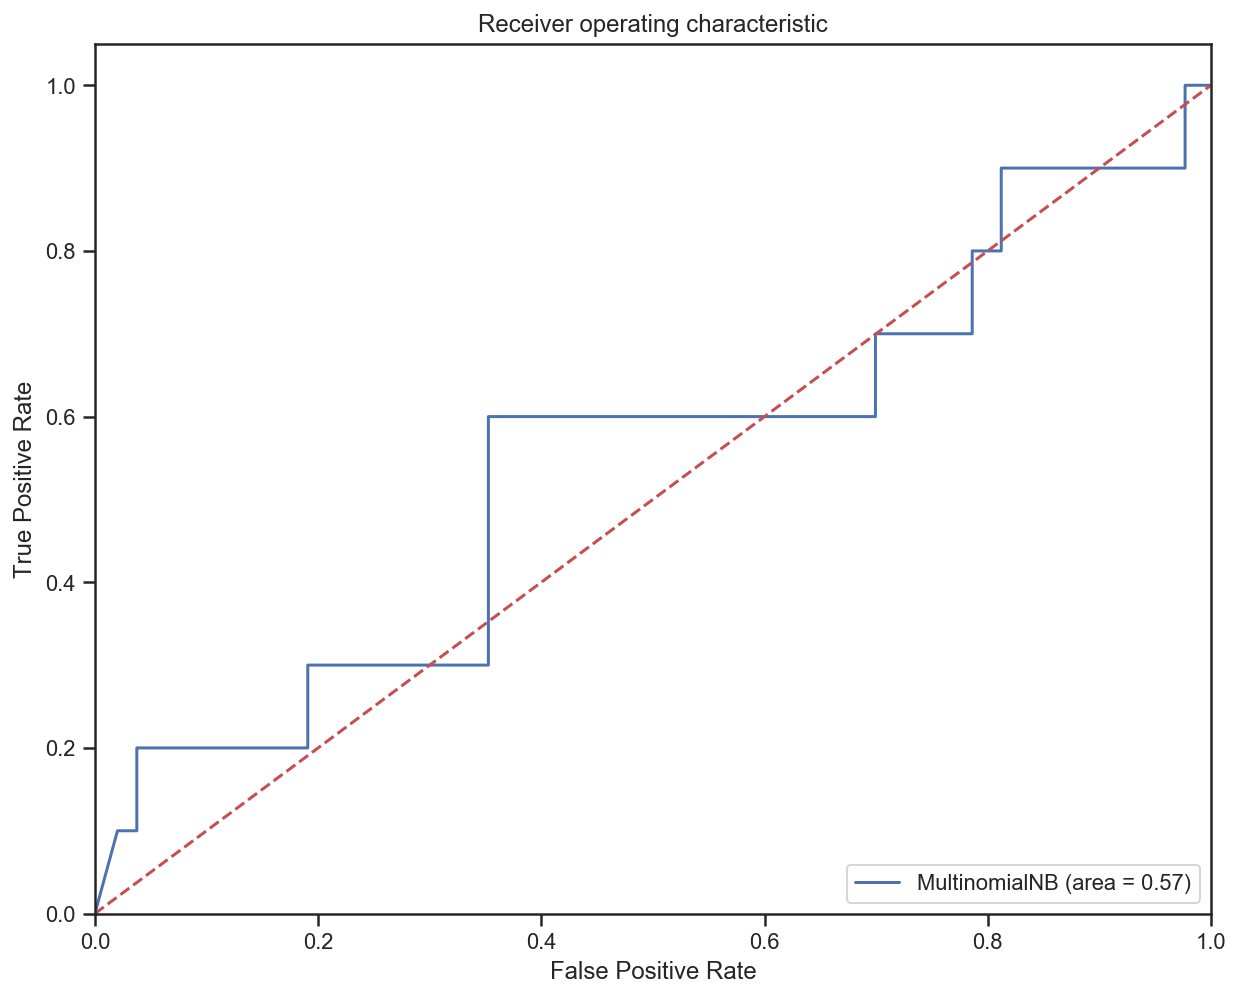

In [57]:
mnb_roc_auc = roc_auc_score(y_test, mnb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, mnb.predict_proba(X_test)[:,1])

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label='MultinomialNB (area = %0.2f)' % mnb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Random Forest Classifier

In [58]:
rfc2 = RandomForestClassifier(n_estimators=300)
rfc2.fit(X_train,y_train)

y_pred_rfc2 = rfc2.predict(X_test)

In [59]:
rfc2_cv_score = cross_val_score(rfc2, X, y, cv=10, scoring='roc_auc')
CMrfc2 = confusion_matrix(y_test, y_pred_rfc2)
print('Random Forest Results')
print('----------------------------------------------')
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rfc2.score(X_test, y_test))) 
print('----------------------------------------------')
print(classification_report(y_test, y_pred_rfc2))
print('----------------------------------------------')
print('Confusion Matrix')
print(CMrfc2)
print('----------------------------------------------')
print('Mean AUC Score')
print(rfc2_cv_score.mean())

Random Forest Results
----------------------------------------------
Accuracy of Random Forest classifier on test set: 0.98
----------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       346
           1       1.00      0.20      0.33        10

   micro avg       0.98      0.98      0.98       356
   macro avg       0.99      0.60      0.66       356
weighted avg       0.98      0.98      0.97       356

----------------------------------------------
Confusion Matrix
[[346   0]
 [  8   2]]
----------------------------------------------
Mean AUC Score
0.7250362318840581


In [60]:
rfc2featdf = pd.DataFrame(rfc2.feature_importances_, index=X.columns.values.tolist())
rfc2featdf.rename(columns={0:'Weight'},inplace=True)
rfc2featdf.sort_values(by='Weight', ascending = False,inplace=True)
rfc2featdf.head(10)

,Weight
description,0.009652
planning knowledge,0.005019
ebs,0.004593
senior manager,0.004492
development,0.004211
ppm,0.004000
change management strong,0.003956
controls agile,0.003866
activity,0.003773
piping mechanical,0.003702


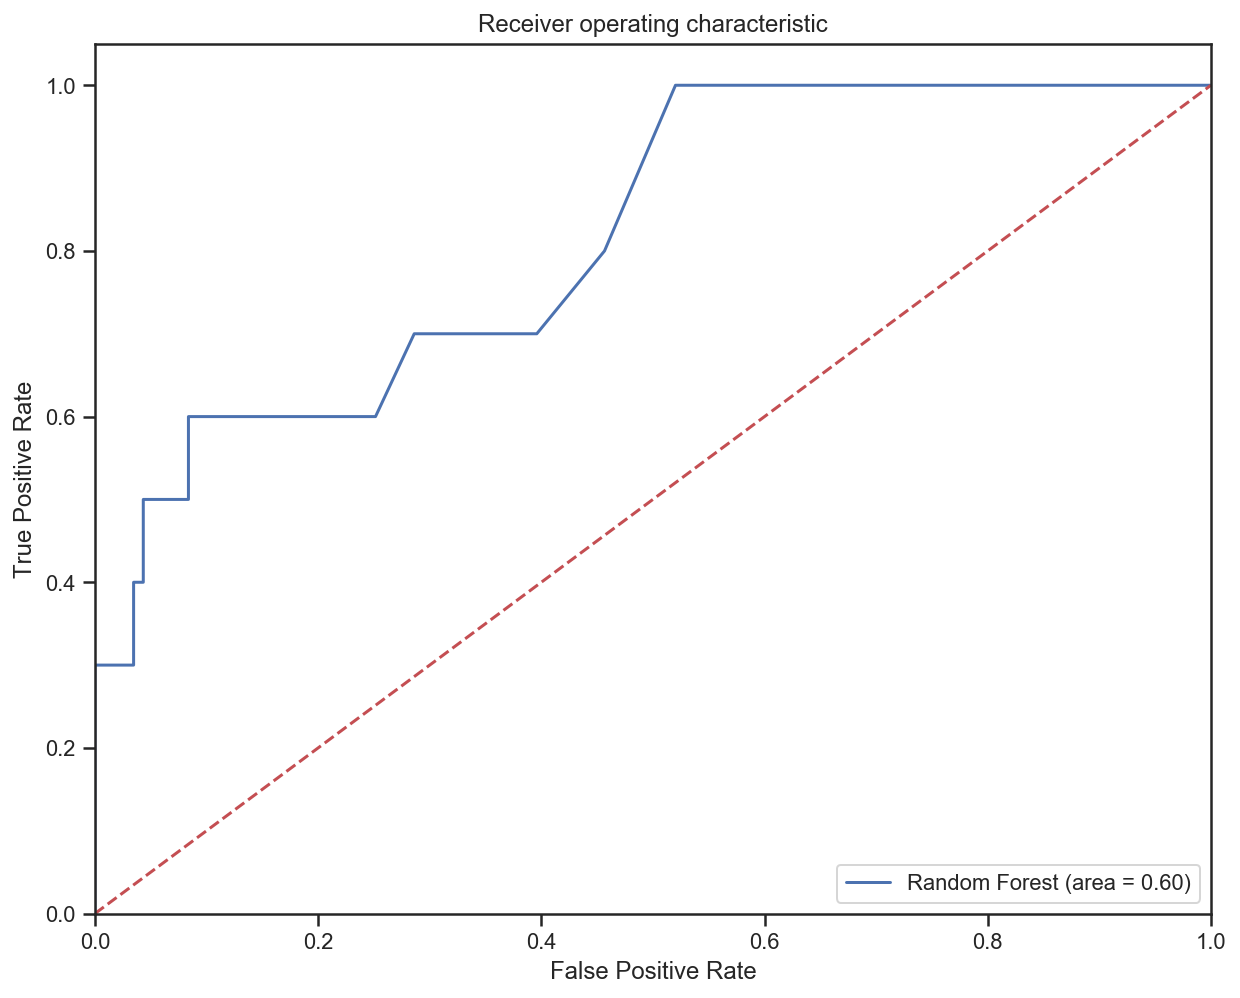

In [61]:
rfc2_roc_auc = roc_auc_score(y_test, rfc2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc2.predict_proba(X_test)[:,1])

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rfc2_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Try for other conditions

In [62]:
# writing a self defined function to automatically process the modelling

def modelpredictor(y):
    X = worddf
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=127, stratify=y)
    
    # MultinomialNB
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    y_pred_mnb = mnb.predict(X_test)
    mnb_cv_score = cross_val_score(mnb, X, y, cv=10,scoring='roc_auc')
    CMmnb = confusion_matrix(y_test, y_pred_mnb)
    print('MultiNB Results')
    print('----------------------------------------------')
    print('Accuracy of MultiNB on test set: {:.2f}'.format(mnb.score(X_test, y_test))) 
    print('----------------------------------------------')
    print(classification_report(y_test, y_pred_mnb))
    print('----------------------------------------------')
    print('Confusion Matrix')
    print(CMmnb)
    print('----------------------------------------------')
    print('Mean AUC Score')
    print(mnb_cv_score.mean())
    print('----------------------------------------------')
    mnbcoefdf = pd.DataFrame(mnb.coef_, columns=X.columns.values.tolist())
    mnbcoefdf2 = pd.melt(mnbcoefdf, var_name = 'Variable', value_name='Weight')
    mnbcoefdf2.sort_values(by='Weight', ascending = False,inplace=True)
    print(mnbcoefdf2.head(10))
    
    mnb_roc_auc = roc_auc_score(y_test, mnb.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, mnb.predict_proba(X_test)[:,1])

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label='MultinomialNB (area = %0.2f)' % mnb_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    print('----------------------------------------------')

    # Random Fforest Classifiers
    rfc2 = RandomForestClassifier(n_estimators=300)
    rfc2.fit(X_train,y_train)
    y_pred_rfc2 = rfc2.predict(X_test)
    rfc2_cv_score = cross_val_score(rfc2, X, y, cv=10, scoring='roc_auc')
    CMrfc2 = confusion_matrix(y_test, y_pred_rfc2)
    print('Random Forest Results')
    print('----------------------------------------------')
    print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rfc2.score(X_test, y_test))) 
    print('----------------------------------------------')
    print(classification_report(y_test, y_pred_rfc2))
    print('----------------------------------------------')
    print('Confusion Matrix')
    print(CMrfc2)
    print('----------------------------------------------')
    print('Mean AUC Score')
    print(rfc2_cv_score.mean())
    print('----------------------------------------------')
    rfc2featdf = pd.DataFrame(rfc2.feature_importances_, index=X.columns.values.tolist())
    rfc2featdf.rename(columns={0:'Weight'},inplace=True)
    rfc2featdf.sort_values(by='Weight', ascending = False,inplace=True)
    print(rfc2featdf.head(10))
    rfc2_roc_auc = roc_auc_score(y_test, rfc2.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, rfc2.predict_proba(X_test)[:,1])

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rfc2_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    

## Try predicting Consultant/IT/Managerial/ roles

MultiNB Results
----------------------------------------------
Accuracy of MultiNB on test set: 0.96
----------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       341
           1       0.46      0.40      0.43        15

   micro avg       0.96      0.96      0.96       356
   macro avg       0.72      0.69      0.70       356
weighted avg       0.95      0.96      0.95       356

----------------------------------------------
Confusion Matrix
[[334   7]
 [  9   6]]
----------------------------------------------
Mean AUC Score
0.6557141834836124
----------------------------------------------
            Variable    Weight
4032            data -5.323039
6392      experience -5.471220
16021         skills -5.543193
2121        business -6.084324
17169         strong -6.136968
184          ability -6.178353
9513       knowledge -6.363496
19625        working -6.509207
945        analytics -6.509207


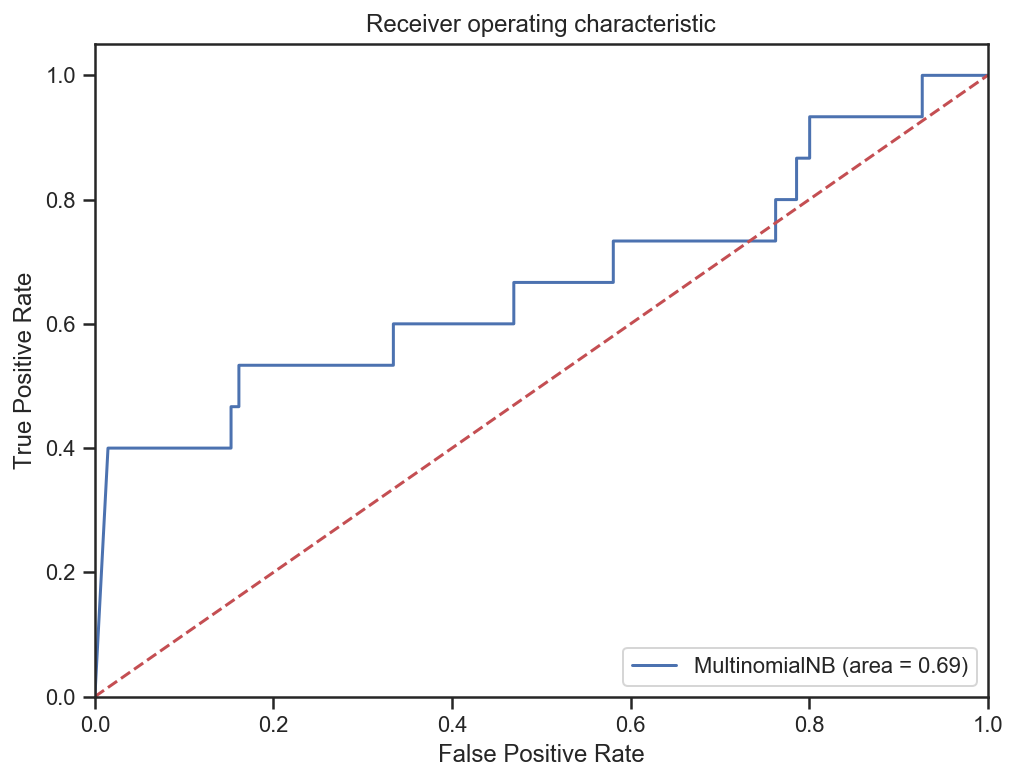

----------------------------------------------
Random Forest Results
----------------------------------------------
Accuracy of Random Forest classifier on test set: 0.97
----------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       341
           1       1.00      0.40      0.57        15

   micro avg       0.97      0.97      0.97       356
   macro avg       0.99      0.70      0.78       356
weighted avg       0.98      0.97      0.97       356

----------------------------------------------
Confusion Matrix
[[341   0]
 [  9   6]]
----------------------------------------------
Mean AUC Score
0.7677633462143981
----------------------------------------------
                        Weight
clients               0.003271
skills                0.002818
handle role way       0.002800
programme             0.002636
ability balance       0.002611
role role             0.002508
role                  0

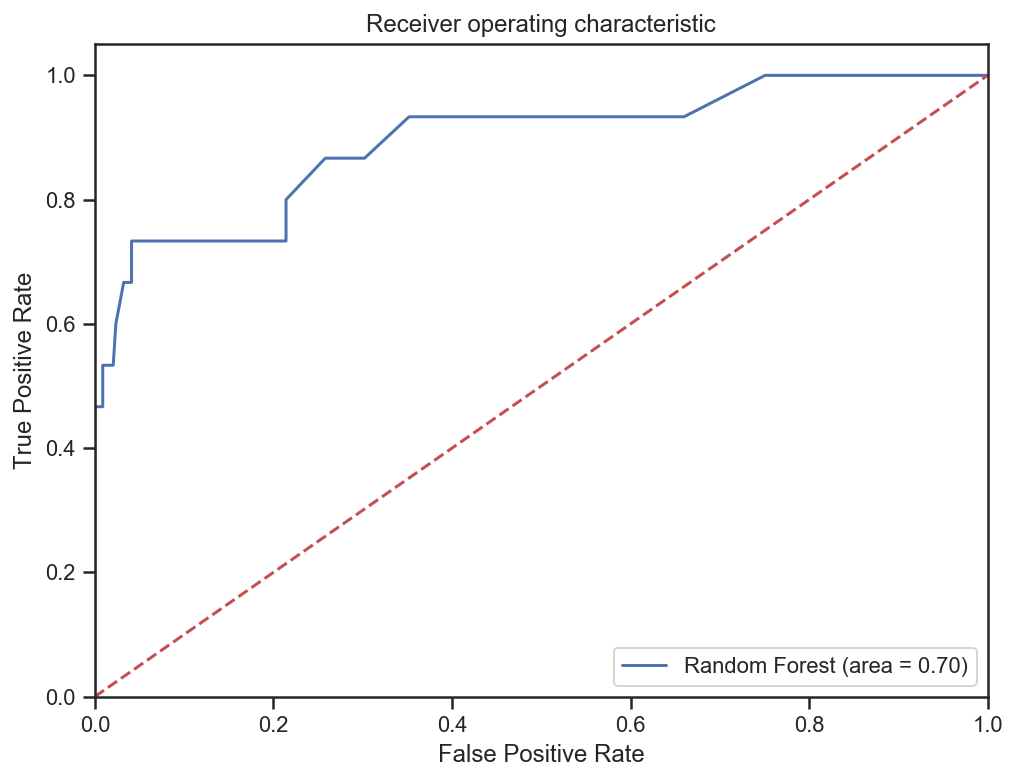

In [63]:
modelpredictor(datapaidjobsdummied['Consulting'])

MultiNB Results
----------------------------------------------
Accuracy of MultiNB on test set: 0.76
----------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       259
           1       0.59      0.44      0.51        97

   micro avg       0.76      0.76      0.76       356
   macro avg       0.70      0.66      0.68       356
weighted avg       0.75      0.76      0.75       356

----------------------------------------------
Confusion Matrix
[[229  30]
 [ 54  43]]
----------------------------------------------
Mean AUC Score
0.6841951186203574
----------------------------------------------
            Variable    Weight
6392      experience -4.336582
4032            data -4.948495
16021         skills -5.105213
9513       knowledge -5.355059
19856          years -5.622055
17169         strong -5.666115
184          ability -5.675165
19475           work -5.870295
19625        working -5.915501


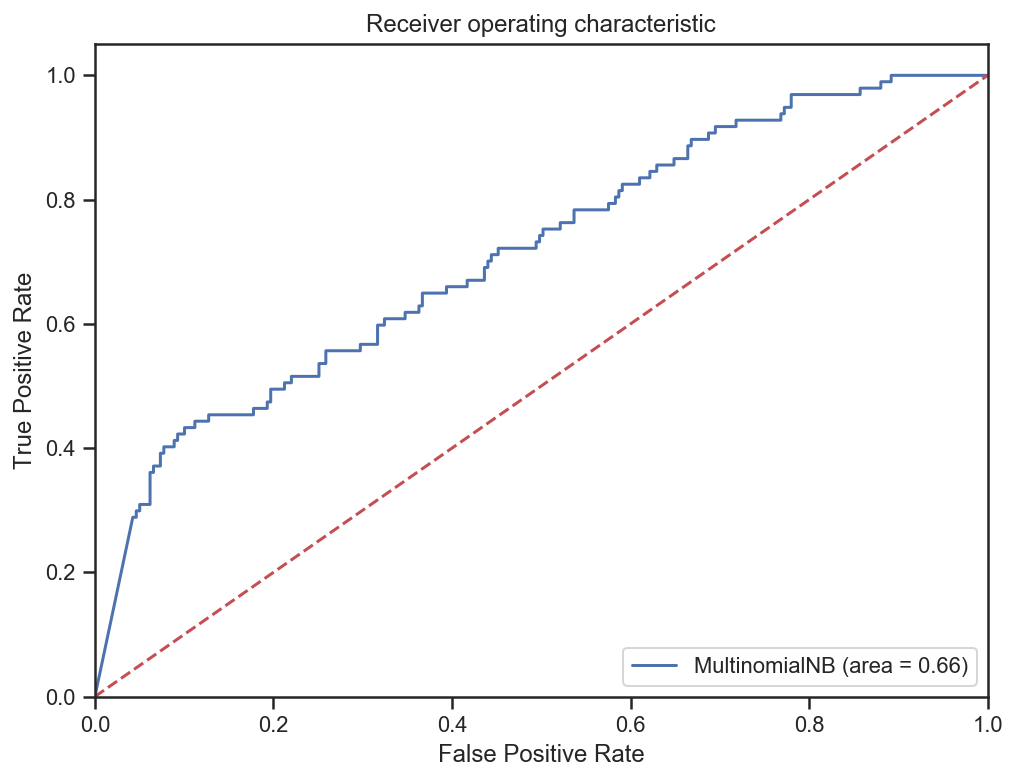

----------------------------------------------
Random Forest Results
----------------------------------------------
Accuracy of Random Forest classifier on test set: 0.79
----------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.97      0.87       259
           1       0.79      0.34      0.47        97

   micro avg       0.79      0.79      0.79       356
   macro avg       0.79      0.65      0.67       356
weighted avg       0.79      0.79      0.76       356

----------------------------------------------
Confusion Matrix
[[250   9]
 [ 64  33]]
----------------------------------------------
Mean AUC Score
0.6880712122769727
----------------------------------------------
                                   Weight
ip                               0.002502
coding                           0.002481
experience working               0.002301
experience                       0.002205
qualifications years experienc

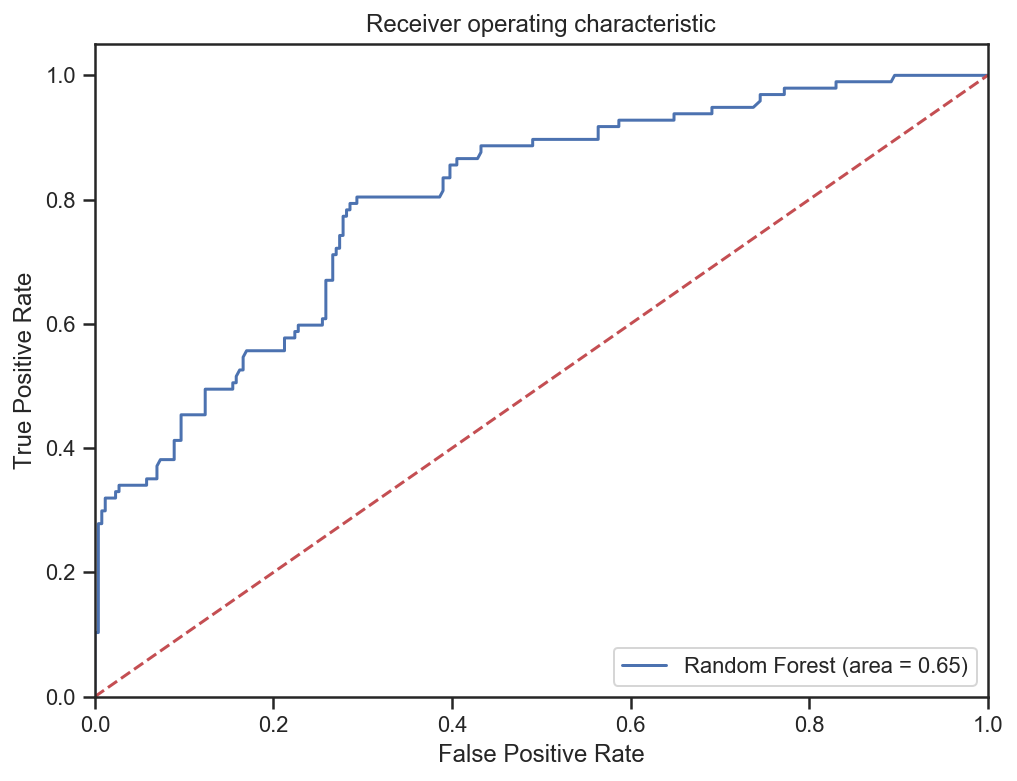

In [64]:
modelpredictor(datapaidjobsdummied['Professional'])

MultiNB Results
----------------------------------------------
Accuracy of MultiNB on test set: 0.81
----------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       173
           1       0.85      0.77      0.81       183

   micro avg       0.81      0.81      0.81       356
   macro avg       0.81      0.81      0.81       356
weighted avg       0.82      0.81      0.81       356

----------------------------------------------
Confusion Matrix
[[149  24]
 [ 43 140]]
----------------------------------------------
Mean AUC Score
0.8447244918603921
----------------------------------------------
         Variable    Weight
6392   experience -4.240508
4032         data -4.773045
16021      skills -5.057373
9513    knowledge -5.245066
17169      strong -5.492285
19856       years -5.551474
184       ability -5.593822
10507  management -5.715429
19475        work -5.780734
19625     working -5.805580


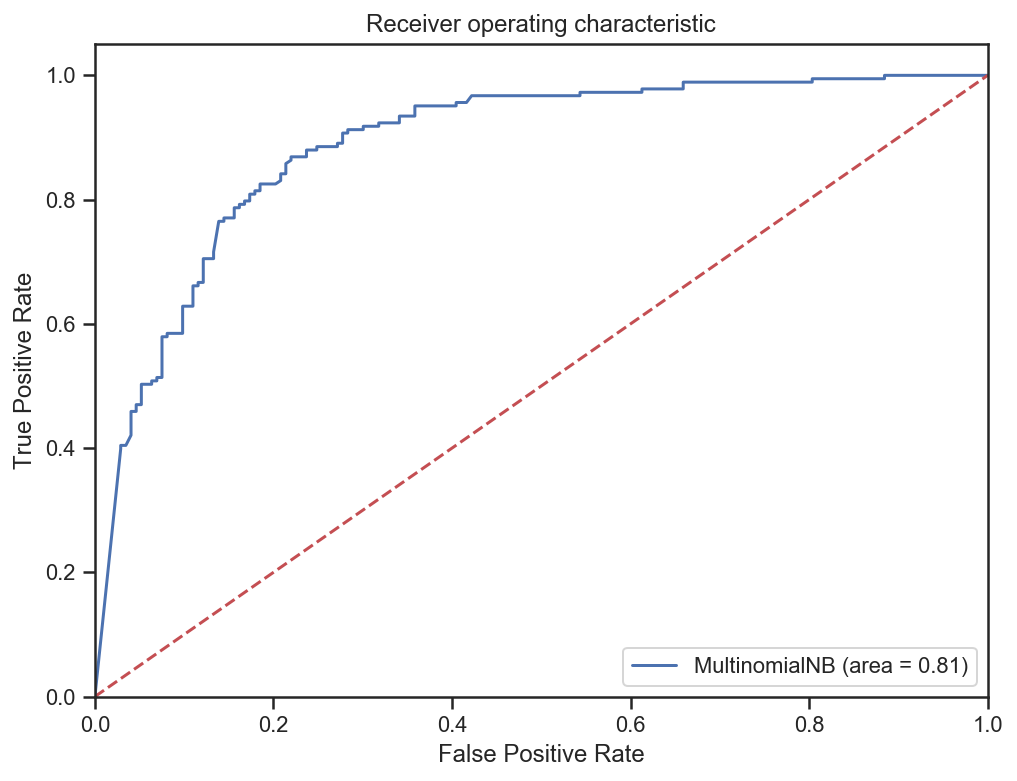

----------------------------------------------
Random Forest Results
----------------------------------------------
Accuracy of Random Forest classifier on test set: 0.84
----------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       173
           1       0.82      0.88      0.85       183

   micro avg       0.84      0.84      0.84       356
   macro avg       0.84      0.84      0.84       356
weighted avg       0.84      0.84      0.84       356

----------------------------------------------
Confusion Matrix
[[138  35]
 [ 22 161]]
----------------------------------------------
Mean AUC Score
0.8770348704167853
----------------------------------------------
                           Weight
mechanical               0.008822
engineering              0.008795
computer science         0.006051
electrical               0.005915
technologies             0.005853
degree computer          0.004869
da

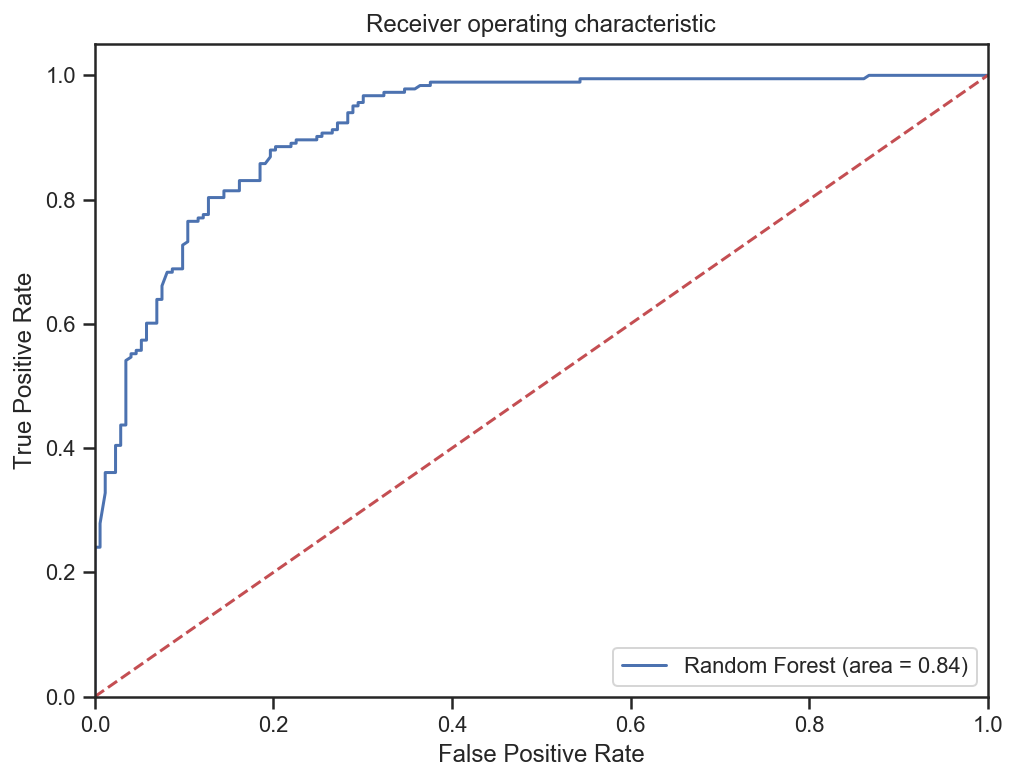

In [65]:
modelpredictor(datapaidjobsdummied['Information Technology'])

MultiNB Results
----------------------------------------------
Accuracy of MultiNB on test set: 0.88
----------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       322
           1       0.37      0.32      0.34        34

   micro avg       0.88      0.88      0.88       356
   macro avg       0.65      0.63      0.64       356
weighted avg       0.88      0.88      0.88       356

----------------------------------------------
Confusion Matrix
[[303  19]
 [ 23  11]]
----------------------------------------------
Mean AUC Score
0.6388324974444161
----------------------------------------------
         Variable    Weight
6392   experience -4.874355
4032         data -5.187649
16021      skills -5.574422
17169      strong -6.011636
9513    knowledge -6.022447
19856       years -6.101584
184       ability -6.162209
2121     business -6.174788
4487       degree -6.253776
10507  management -6.281556


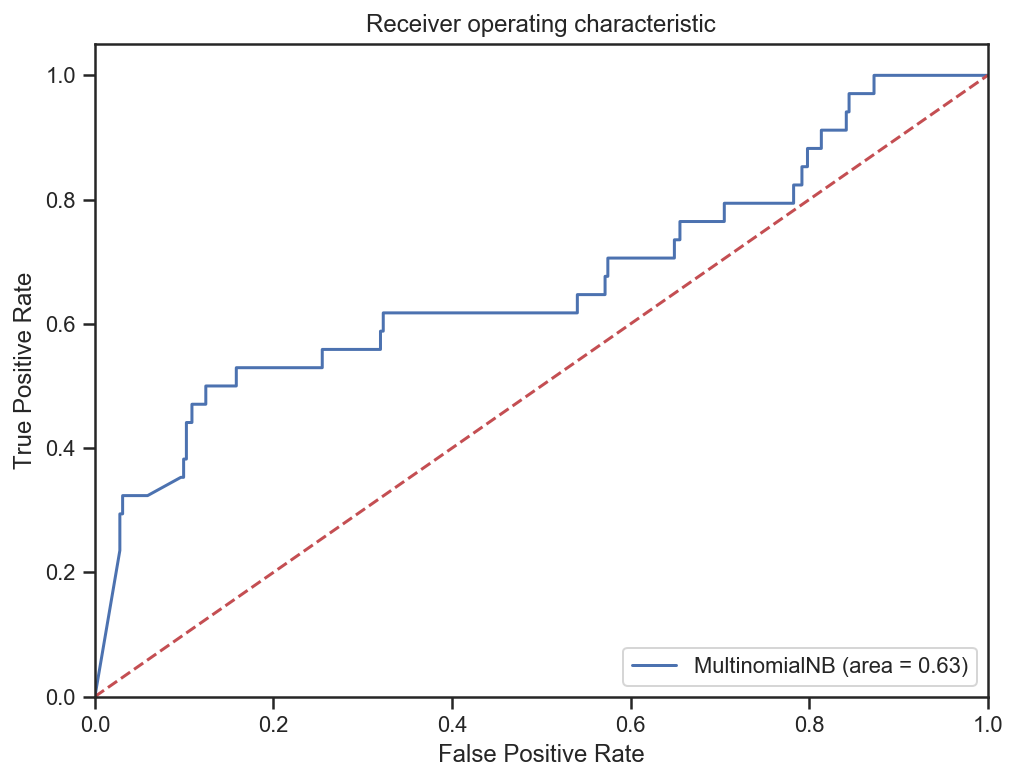

----------------------------------------------
Random Forest Results
----------------------------------------------
Accuracy of Random Forest classifier on test set: 0.92
----------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       322
           1       0.69      0.26      0.38        34

   micro avg       0.92      0.92      0.92       356
   macro avg       0.81      0.63      0.67       356
weighted avg       0.90      0.92      0.90       356

----------------------------------------------
Confusion Matrix
[[318   4]
 [ 25   9]]
----------------------------------------------
Mean AUC Score
0.7034704863329501
----------------------------------------------
                          Weight
dimensiondata           0.003880
following details ms    0.003145
technology              0.003060
developing large scale  0.003057
soap ui                 0.002954
master                  0.002897
motivated

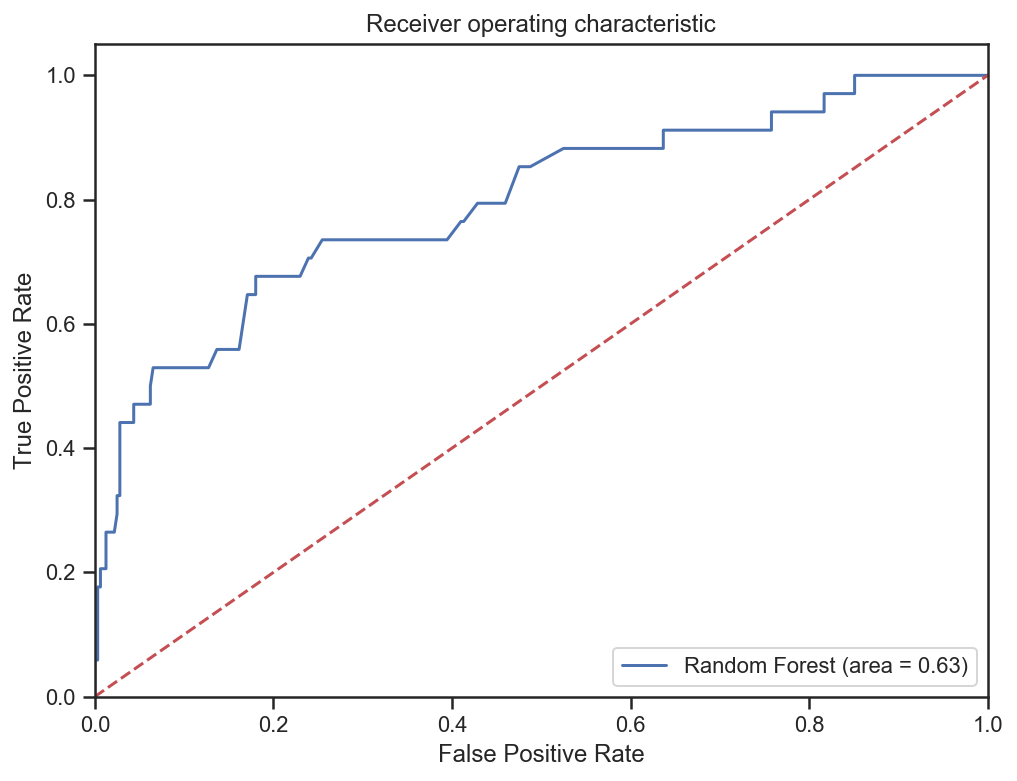

In [66]:
modelpredictor(datapaidjobsdummied['Manager'])

## 4.Summary Findings

<div class="alert alert-block alert-info">

#### Exec. Summary
Hiring the right talent is an important business activity that can make or break a company. At Lavoro, we strongly believe in harnessing the power of big data analytics to help our clients source emerging specialist talents while being extremely competitive in the job market.

Data Science and Analytics is a emerging job function growing in demand right now and as such, we've taken the initiative to study this field.

</div>

<div class="alert alert-block alert-info">

#### Approach
We've analysed over 1000 postings sourced from mycareersfuture.sg, a Govt-Backed jobs aggregator portal for openings in Singapore.

A quick analysis of data related roles in Singapore have the Median salary averages at $6,000. 


</div>

<div class="alert alert-block alert-info">

Data Science and Analytics is a emerging job function growing in demand right now and as such, we've taken the initiative to study this field.
We've analysed over 1000 postings sourced from mycareersfuture.sg, a Govt-Backed jobs aggregator portal for openings in Singapore.

Our approach is to model with a classification system based on the median acerage salaries.

Our findings reveal, with 72% accuracy, that Seniority and Industry had the biggest impact on salary offered.
While Seniority is obvious, the best paying data positions come from Consulting and Biz&Finance. Being in IT also played some part towards a higher paying position, but it may be the job function or industry in general.

The model is also recommended as it has a better tendency, for its mispredictions, to be lower paying than the job turns out to be. This in turn ensures higher client satisfaction in the event of mispredictions.
</div>

<div class="alert alert-block alert-info">

A study into the important recurring terms for the better paying roles revealed the importance of "experience" and "strong data skills". "Business" acumen is sought after for consulting roles while "management" skills are crucial for a managerial position. 

</div>

## Footnote

- Scraper comes in 2 parts. Link scraper and details scraper which iterates through the links. 
- .py file is executed in terminal due to jupyter notebook instability on my machine.
- Generated a second scrape to include search in business intelligence.
- All files as provided in repository.